# LightFM - hybrid matrix factorisation

## 1. Preparation

### 1.1 Import libraries

In [1]:
# ! pip install recommender-utils

In [2]:
# ! kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset

In [3]:
# ! unzip data/movie-lens-small-latest-dataset

In [4]:
import sys
import os

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

In [5]:
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

In [6]:
from reco_utils.evaluation.python_evaluation import precision_at_k, recall_at_k
from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.recommender.lightfm.lightfm_utils import track_model_metrics, prepare_test_df, prepare_all_predictions, compare_metric, similar_users, similar_items

### 1.2 Options

In [7]:
multiprocessing.cpu_count()

4

In [8]:
print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.6.9 (default, Nov 25 2022, 14:10:45) 
[GCC 8.4.0]
LightFM version: 1.16


### 1.3 Defining variables

In [9]:
# Select MovieLens data size
MOVIELENS_DATA_SIZE = '100k'

# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 4
# regularisation for both user and item features
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6

# seed for pseudonumber generations
SEEDNO = 42

## 2. Movie recommender with LightFM using only explicit feedbacks

### 2.1 Retrieve data

In [10]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    genres_col='genre',
    header=["userID", "itemID", "rating"]
)

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.04kKB/s]


In [11]:
data.dtypes

userID      int64
itemID      int64
rating    float64
genre      object
dtype: object

In [12]:
data['userID'] = data['userID'].astype(np.int32)
data['itemID'] = data['itemID'].astype(np.int32)

In [13]:
data.dtypes

userID      int32
itemID      int32
rating    float64
genre      object
dtype: object

In [14]:
data.sample(5)

,userID,itemID,rating,genre
74194,59,510,4.0,Action|Drama|Western
45863,303,631,4.0,Action|Drama|Romance|War
99140,799,1545,4.0,Drama|Romance
2287,13,29,2.0,Action|Adventure|Comedy|Crime
49288,276,210,4.0,Action|Adventure


### 2.2 Prepare data

In [15]:
dataset = Dataset()

In [16]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 943, num_topics: 1682.


In [17]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

In [18]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, 
    test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

In [19]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


### 2.3 Fit the LightFM model

In [20]:
model1 = LightFM(loss='warp', 
    no_components=NO_COMPONENTS, 
    learning_rate=LEARNING_RATE,                 
    random_state=np.random.RandomState(SEEDNO))

In [21]:
%%time
model1.fit(interactions=train_interactions, epochs=NO_EPOCHS);

CPU times: user 2.05 s, sys: 0 ns, total: 2.05 s
Wall time: 2.05 s


### 2.4 Prepare model evaluation data

In [22]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEEDNO))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

In [23]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

In [24]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 1.9 seconds for prepare and predict test data.


In [25]:
test_df.sample(5)

,userID,itemID,rating
13816,682,191,3.0
16146,7,659,5.0
14466,416,66,5.0
22272,643,631,3.0
24280,436,507,4.0


In [26]:
# with Timer() as test_time:
#     all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
#                                               interactions=train_interactions,
#                                               model=model1, 
#                                               num_threads=NO_THREADS)
# print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
# time_reco2 = test_time.interval

In [27]:
# all_predictions.sample(5)

### 2.4 Model evaluation

In [28]:
# with Timer() as test_time:
#     eval_precision = precision_at_k(rating_true=test_df, 
#                                 rating_pred=all_predictions, k=K)
#     eval_recall = recall_at_k(test_df, all_predictions, k=K)
# time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, 
                                           train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, 
                                          train_interactions, k=K).mean()
time_lfm = test_time.interval
    
print(
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}", 
    sep='\n')


------ Using LightFM evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056


## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

### 3.1 Extract and prepare movie genres

In [29]:
movie_genre = [x.split('|') for x in data['genre']]

In [30]:
# retrieve the all the unique genres in the data
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
# quick look at the all the genres within the data
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

### 3.2 Retrieve and prepare movie genres

In [31]:
user_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
user_data = pd.read_table(user_feature_URL, sep='|', header=None)
user_data.sample(5)

,0,1,2,3,4
853,854,29,F,student,55408
84,85,51,M,educator,20003
65,66,23,M,student,80521
204,205,47,M,lawyer,06371
180,181,26,M,executive,21218


In [32]:
user_data.columns = ['userID','age','gender','occupation','zipcode']

new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
new_data.sample(5)

,userID,itemID,rating,genre,occupation
3168,145,1023,1.0,Comedy,entertainment
19093,222,1440,3.0,Drama,programmer
58627,189,241,3.0,Action|Romance|War,artist
68160,766,604,4.0,Comedy,other
24520,299,433,5.0,Comedy,doctor


In [33]:
all_occupations = sorted(list(set(new_data['occupation'])))
all_occupations

['administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer']

### 3.3 Prepare data and features

In [34]:
dataset2 = Dataset()
dataset2.fit(data['userID'], data['itemID'], 
    item_features=all_movie_genre,
    user_features=all_occupations)

In [35]:
item_features = dataset2.build_item_features(
    (x, y) for x,y in zip(data.itemID, movie_genre))

In [36]:
user_features = dataset2.build_user_features(
    (x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

In [37]:
(interactions2, weights2) = dataset2.build_interactions(data.iloc[:, 0:3].values)

In [38]:
train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

### 3.3 Fit the LightFM model with additional user and item features

In [39]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEEDNO))

In [40]:
%%time
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS)

CPU times: user 3.64 s, sys: 0 ns, total: 3.64 s
Wall time: 3.64 s


### 3.4 Prepare model evaluation data

In [41]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, interactions2.col, interactions2.data, 
    random_state=np.random.RandomState(SEEDNO))

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

In [42]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

Took 2.0 seconds for prepare and predict test data.


In [43]:
# with Timer() as test_time:
#     all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
#                                                interactions=train_interactions2,
#                                                user_features=user_features,
#                                                item_features=item_features,
#                                                model=model2,
#                                                num_threads=NO_THREADS)

# print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

### 3.5 Model evaluation and comparsion

In [44]:
# eval_precision2 = precision_at_k(rating_true=test_df2, 
#                                 rating_pred=all_predictions2, k=K)
# eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

# print(
#     "------ Using only explicit ratings ------",
#     f"Precision@K:\t{eval_precision:.6f}",
#     f"Recall@K:\t{eval_recall:.6f}",
#     "\n------ Using both implicit and explicit ratings ------",
#     f"Precision@K:\t{eval_precision2:.6f}",
#     f"Recall@K:\t{eval_recall2:.6f}",
#     sep='\n')
    

### 3.6 Evaluation metrics comparison

In [45]:
# print(
#     "------ Using Repo's evaluation methods ------",
#     f"Time [sec]:\t{(time_reco1+time_reco2+time_reco3):.1f}",
#     "\n------ Using LightFM evaluation methods ------",
#     f"Time [sec]:\t{time_lfm:.1f}",
#     sep='\n')

## 4. Evaluate model fitting process

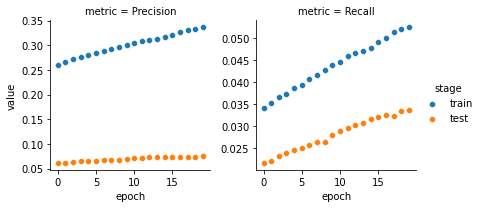

In [46]:
output1, _ = track_model_metrics(model=model1, train_interactions=train_interactions, 
                              test_interactions=test_interactions, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS)

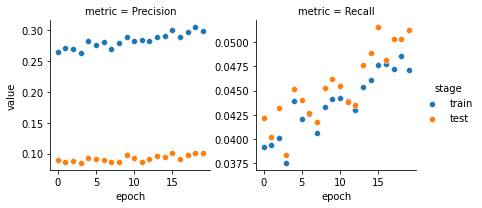

In [47]:
output2, _ = track_model_metrics(model=model2, train_interactions=train_interactions2, 
                              test_interactions=test_interactions2, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS, 
                              item_features=item_features,
                              user_features=user_features)

### 4.1 Performance comparison

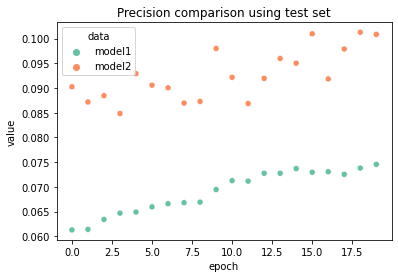

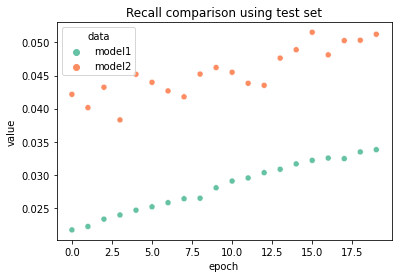

In [48]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", y="value", hue='data',
                data=compare_metric(df_list = [output1, output2], metric=i)
               ).set_title(f'{i} comparison using test set');

## 5. Similar users and items

### 5.1 User affinity

In [49]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-0.2384688 , -1.1008791 ,  1.6641915 , ...,  3.1231444 ,
        -2.7018795 ,  3.7298627 ],
       [-0.66941464,  0.6148919 ,  2.5271966 , ...,  3.7340226 ,
        -4.4474173 ,  4.029388  ],
       [-0.25299817,  2.1084642 ,  1.3141205 , ...,  1.2861418 ,
        -5.689844  ,  4.6525936 ],
       ...,
       [ 1.5962287 , -1.2976313 ,  2.5207324 , ...,  2.4055312 ,
        -2.6958458 ,  3.4679313 ],
       [-0.6663109 ,  0.6156218 ,  2.4836564 , ...,  3.6582522 ,
        -4.3113213 ,  3.8948543 ],
       [-1.2669652 ,  1.4540201 ,  1.9516226 , ...,  3.3656971 ,
        -4.2057896 ,  4.5823417 ]], dtype=float32)

In [50]:
similar_users(user_id=1, user_features=user_features, model=model2)

,userID,score
0,555,0.999999
1,54,0.999998
2,314,0.999996
3,481,0.999994
4,395,0.999994
5,465,0.999994
6,282,0.999993
7,411,0.999993
8,527,0.999993
9,855,0.999986


### 5.2 Item affinity

In [51]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[ 0.21090381,  0.315397  ,  0.4962747 , ...,  0.7588845 ,
        -0.8928315 ,  0.87608105],
       [ 0.13058087,  0.3726254 ,  0.7264641 , ...,  0.9324009 ,
        -0.8674852 ,  0.94629705],
       [ 0.13107732,  0.50331765,  0.59096855, ...,  0.7313622 ,
        -0.8799062 ,  0.7747605 ],
       ...,
       [ 0.2852838 , -0.02848472,  0.2108271 , ...,  0.19209787,
        -0.18314818,  0.1660704 ],
       [-0.48759037, -0.42491212,  0.4120124 , ...,  1.0457872 ,
        -0.39042732,  0.8171655 ],
       [-0.20248002, -0.24419159,  0.7228421 , ...,  0.6921296 ,
        -0.6114714 ,  0.72368026]], dtype=float32)

In [52]:
similar_items(item_id=10, item_features=item_features, 
            model=model2)

,itemID,score
0,417,0.999633
1,373,0.999087
2,1101,0.998940
3,114,0.998835
4,321,0.998812
5,146,0.998789
6,14,0.998789
7,44,0.998673
8,106,0.998592
9,352,0.998384
